In [1]:
%matplotlib inline
import torch
import random
import graphviz
from torchviz import make_dot
from d2l import torch as d2l

In [2]:
def synthetic_data(w, b, num):  #@save
    """ y = Xw + b + noise """
    X = torch.normal(0, 1, (num, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)

    return X, y.reshape((-1, 1))

In [3]:
w_true = torch.tensor([2, -3.4])
b_true = 4.2

In [4]:
features, labels = synthetic_data(w_true, b_true, 1000)
features, labels
features.size(), labels.size()  # len(features) = 1000

(torch.Size([1000, 2]), torch.Size([1000, 1]))

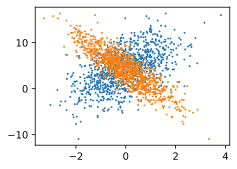

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 0].detach().numpy(), labels.detach().numpy(), 1);
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # print(indices[i: min(i + batch_size, num_examples)])
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])

        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, "\n", y)
    break

tensor([[ 3.8173, -1.2289],
        [ 1.3879,  1.0804],
        [-0.1072, -0.0927],
        [-0.1864, -0.7724],
        [-1.8278,  0.2908],
        [ 0.4236,  1.4663],
        [ 2.3528,  2.4657],
        [-2.1244,  1.6458],
        [ 0.5644,  0.3381],
        [-1.2550,  0.3351]]) 
 tensor([[15.9978],
        [ 3.2977],
        [ 4.2984],
        [ 6.4567],
        [-0.4576],
        [ 0.0700],
        [ 0.5197],
        [-5.6399],
        [ 4.1865],
        [ 0.5456]])


## Linear Regression

$$
\mathbf{y} = \mathbf{X} \cdot \mathbf{w} + b
$$

In [8]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [9]:
def squared_loss(y_hat, y):  #@save
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

$$
\theta := \theta - \eta \cdot \dfrac{1}{B} \nabla_{\theta}{L(\theta)}
$$

In [10]:
def sgd(params, lr, batch_size):
    """ Small-batch stochastic gradient descent """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [11]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)  # enable the automatic differentiation function

In [12]:
## Training
lr = 0.02
iter_num = 10
for i in range(iter_num):
    for X, y in data_iter(batch_size, features, labels):
        loss = squared_loss(linreg(X, w, b), y)
        loss.sum().backward()
        sgd([w, b], lr, batch_size)

    with torch.no_grad():
        train_loss = squared_loss(linreg(features, w, b), labels)
        print(f"iter: {i + 1:2d}, loss: {float(train_loss.mean()):f}")

iter:  1, loss: 0.268317
iter:  2, loss: 0.004345
iter:  3, loss: 0.000118
iter:  4, loss: 0.000048
iter:  5, loss: 0.000047
iter:  6, loss: 0.000047
iter:  7, loss: 0.000047
iter:  8, loss: 0.000047
iter:  9, loss: 0.000047
iter: 10, loss: 0.000047


In [13]:
print(f"Estimation error of w: {w_true - w.reshape(w_true.shape)}")
print(f"Estimation error of b: {b_true - b}")

Estimation error of w: tensor([ 6.4254e-05, -2.8443e-04], grad_fn=<SubBackward0>)
Estimation error of b: tensor([-0.0001], grad_fn=<RsubBackward1>)


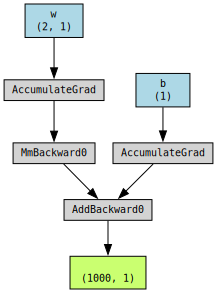

In [14]:
make_dot(linreg(features, w, b), params={'w': w, 'b': b})

## Simple Implementation

In [15]:
import numpy as np
from torch import nn
from torch.utils import data

In [16]:
w_true = torch.tensor([2, -3.4])
b_true = 4.2

features, labels = d2l.synthetic_data(w_true, b_true, 1000)

In [17]:
def load_array(data_arr, batch_size, is_train=True):  #@save
    dataset = data.TensorDataset(*data_arr)

    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [18]:
bathc_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-1.2661, -0.4713],
         [ 1.5864,  0.3146],
         [-0.3065, -0.2790],
         [ 1.1314,  0.0510],
         [ 1.3277, -0.1548],
         [-0.0445, -0.1718],
         [-0.3062,  1.5131],
         [-0.1065, -0.1316],
         [ 1.1679,  1.3399],
         [-0.3984, -0.1666]]),
 tensor([[ 3.2639],
         [ 6.3066],
         [ 4.5343],
         [ 6.3071],
         [ 7.3882],
         [ 4.6775],
         [-1.5577],
         [ 4.4534],
         [ 1.9772],
         [ 3.9825]])]

In [19]:
net = nn.Sequential(nn.Linear(2, 1))
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [20]:
loss_func = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.02)

In [21]:
iter_num = 10
for i in range(iter_num):
    for X, y in data_iter:
        loss = loss_func(net(X), y)
        trainer.zero_grad()
        loss.backward()
        trainer.step()
    loss = loss_func(net(features), labels)
    print(f"iter: {i + 1:2d}, loss: {loss:f}")

iter:  1, loss: 0.007795
iter:  2, loss: 0.000104
iter:  3, loss: 0.000103
iter:  4, loss: 0.000103
iter:  5, loss: 0.000103
iter:  6, loss: 0.000103
iter:  7, loss: 0.000103
iter:  8, loss: 0.000103
iter:  9, loss: 0.000103
iter: 10, loss: 0.000103


In [22]:
w = net[0].weight.data
b = net[0].bias.data
print(f"Estimation error of w: {w_true - w.reshape(w_true.shape)}")
print(f"Estimation error of b: {b_true - b}")

Estimation error of w: tensor([-0.0006,  0.0004])
Estimation error of b: tensor([-1.9550e-05])
